# Fantasy Football Stats

This project will help me win my league! Some questions I want answered:
1. Who are the best WR/RB/TE/etc. 
2. Who are the most targeted players?
3. Can we identify sleepers? Regression on
    1. QBR
    2. Targets on Offense
    3. Vacated targets due to injury
    4. Targets per player
    5. Offensive performance.
4. Consistency ratings for players
5. Trade for targets based on: 
    1. Consistency
    2. Outlier performances
    3. Some sleeper stats discussed earlier.


Another resource: https://gist.github.com/nntrn/ee26cb2a0716de0947a0a4e9a157bc1c

1. Injuries can help predict sleepers.
2. Rosters from year to year can help with setting the rookie flag. 


... This is all done in the API. Check out the API then we can create some advanced metrics like sleeper prediction, bust prediction, etc. 


In [2]:
import nfl_data_py as nfl
import pandas as pd
df = nfl.import_pbp_data(years = [2023])

2023 done.
Downcasting floats.


In [3]:
wr_map = df[['receiver_player_id', 'receiver_player_name']].drop_duplicates(subset=['receiver_player_id']).set_index('receiver_player_id').to_dict()['receiver_player_name']


In [4]:
rec_yards = df[(df['complete_pass'] == 1)].groupby(['receiver_player_id', 'receiver_player_name'])['receiving_yards'].sum().reset_index()

In [5]:
rec_yards.sort_values(by=['receiving_yards'], ascending=False).head(20)

,receiver_player_id,receiver_player_name,receiving_yards
54,00-0033040,T.Hill,1014.0
176,00-0035676,A.Brown,939.0
395,00-0039075,P.Nacua,795.0
31,00-0031588,S.Diggs,748.0
131,00-0034827,D.Moore,691.0
268,00-0036963,A.St. Brown,665.0
260,00-0036900,J.Chase,656.0
9,00-0030279,K.Allen,643.0
221,00-0036358,C.Lamb,633.0
205,00-0036261,B.Aiyuk,620.0


In [6]:
targets = df[(df['pass_attempt'] == 1)].groupby(['receiver_player_id', 'receiver_player_name'])['pass_attempt'].count().reset_index().rename({'pass_attempt':'targets'},axis=1)

In [7]:
# looks like there's some discrepancy here specifically with Tyreek Hill.
# NOTE: I think this is fine. There might be some discrepency when it comes to penalties but I want to count it as long as the receiver was looked at. Regardless of penalty. 
targets.sort_values(by=['targets'], ascending=False).head(20)

,receiver_player_id,receiver_player_name,targets
32,00-0031588,S.Diggs,90
414,00-0039075,P.Nacua,89
56,00-0033040,T.Hill,88
270,00-0036900,J.Chase,85
182,00-0035676,A.Brown,83
212,00-0036252,M.Pittman,79
278,00-0036963,A.St. Brown,78
24,00-0031381,D.Adams,78
295,00-0037239,C.Olave,77
10,00-0030279,K.Allen,74


### Player DB

Now that we have a feel for how the dataset works. Let's make a player stats database where we grab
1. *Total Yards*
2. *Average YAC.*
3. *Average Air Yards.*
4. Average Fantasy Points per game TODO: Need to create scoring system. Or just import ESPN data?
5. *Number of targets*
6. *Number of receptions*
7. Avg targets
8. Avg receptions
9. *completion percentage*
10. *% of snaps played*

Let's go game by game first. These stats are *itallic*

Note: you can do analysis on a game-by-game basis and use an LSTM to predict fantasy scores (need to feed in vacated targets/injuries etc.)

In [8]:
# yards per game
rec_yards_game = df[(df['complete_pass'] == 1) & (df['play_type'] != 'no_play')].groupby(['receiver_player_id', 'receiver_player_name', 'game_id'])['receiving_yards'].sum().reset_index()

# number of targets per game
targets_game = df[(df['pass_attempt'] == 1)].groupby(['receiver_player_id', 'receiver_player_name', 'game_id'])['pass_attempt'].count().reset_index().rename({'pass_attempt':'targets'},axis=1)

# average YAC
average_YAC_game = df[(df['complete_pass'] == 1) & (df['play_type'] != 'no_play')].groupby(['receiver_player_id', 'receiver_player_name', 'game_id'])['yards_after_catch'].mean().reset_index().rename({'yards_after_catch':'avg_YAC'},axis=1)

# average air yards (receiver) per game = average depth of target
average_air_yards_game = df[(df['complete_pass'] == 1) & (df['play_type'] != 'no_play')].groupby(['receiver_player_id', 'receiver_player_name', 'game_id'])['air_yards'].mean().reset_index().rename({'air_yards':'avg_air_yards'},axis=1)

# average receptions (receiver) per game
receptions_game = df[(df['complete_pass'] == 1) & (df['play_type'] != 'no_play')].groupby(['receiver_player_id', 'receiver_player_name', 'game_id'])['complete_pass'].count().reset_index().rename({'complete_pass':'receptions'},axis=1)

# num_snaps is a bit more complicated. For each player, we need to count the number of times their player ID appeared in the offensive snaps,
# then we can count the number of offensive snaps and get the percentage from that. 
# def snaps(group):
#     player_list = [y for x in df['offense_players'].to_dict().values() for y in x.split(';') if y != '']
    
#     num_snaps = {}
#     for snap in player_list:
#         if snap in list(num_snaps.keys()):
#             num_snaps[snap] += 1
#         else:
#             num_snaps[snap] = 1
#     return num_snaps
    
# num_snaps = df.groupby(['game_id'])

# redzone targets

# garbage time points? 

# fantasy points per game (PPR)

# % of 1,2 down snaps vs 3,4 down snaps

# max target length
# average air yards (receiver) per game = average depth of target
max_air_yards_game = df[(df['complete_pass'] == 1) & (df['play_type'] != 'no_play')].groupby(['receiver_player_id', 'receiver_player_name', 'game_id'])['air_yards'].max().reset_index().rename({'air_yards':'max_target_length'},axis=1)


In [9]:
# TODO: Need to fill in nulls for players who got nothing in any particular game.
# NOTE: If players were injured then that game shouldn't be considered for them
per_game_stats = pd.concat([rec_yards_game.set_index(['receiver_player_id', 'receiver_player_name', 'game_id']),
    targets_game.set_index(['receiver_player_id', 'receiver_player_name', 'game_id']),
    average_YAC_game.set_index(['receiver_player_id', 'receiver_player_name', 'game_id']),
    average_air_yards_game.set_index(['receiver_player_id', 'receiver_player_name', 'game_id']),
    receptions_game.set_index(['receiver_player_id', 'receiver_player_name', 'game_id']),
    max_air_yards_game.set_index(['receiver_player_id', 'receiver_player_name', 'game_id'])], axis=1).reset_index()
per_game_stats.head()

,receiver_player_id,receiver_player_name,game_id,receiving_yards,targets,avg_YAC,avg_air_yards,receptions,max_target_length
0,00-0024243,M.Lewis,2023_04_DEN_CHI,8.0,1,11.0,-3.0,1.0,-3.0
1,00-0024243,M.Lewis,2023_07_LV_CHI,16.0,1,11.0,5.0,1.0,5.0
2,00-0027696,J.Graham,2023_03_NO_GB,8.0,1,0.0,8.0,1.0,8.0
3,00-0027944,J.Jones,2023_07_MIA_PHI,3.0,1,1.0,2.0,1.0,2.0
4,00-0027944,J.Jones,2023_08_PHI_WAS,8.0,2,0.0,8.0,1.0,8.0


In [10]:
total_stats = per_game_stats.drop('game_id', axis=1).groupby(['receiver_player_id', 'receiver_player_name']).agg(
    {
        'receiving_yards':'sum',
        'targets':'sum',
        'avg_YAC':'mean',
        'avg_air_yards':'mean',
        'receptions':'sum',
        'max_target_length':'max'
    }
).reset_index()
total_stats.sort_values('receiving_yards', ascending=False).head(20)

,receiver_player_id,receiver_player_name,receiving_yards,targets,avg_YAC,avg_air_yards,receptions,max_target_length
56,00-0033040,T.Hill,1014.0,88,6.229167,10.785196,61.0,42.0
182,00-0035676,A.Brown,939.0,83,4.787599,10.508234,60.0,42.0
414,00-0039075,P.Nacua,795.0,89,5.252083,7.927579,61.0,36.0
32,00-0031588,S.Diggs,748.0,90,3.495387,8.513740,64.0,48.0
134,00-0034827,D.Moore,691.0,58,6.528125,8.387500,44.0,32.0
278,00-0036963,A.St. Brown,665.0,78,4.396031,8.110562,57.0,34.0
270,00-0036900,J.Chase,656.0,85,5.364625,4.965646,60.0,51.0
10,00-0030279,K.Allen,643.0,74,3.811224,8.141724,54.0,38.0
230,00-0036358,C.Lamb,633.0,56,5.141311,8.663111,46.0,29.0
214,00-0036261,B.Aiyuk,620.0,52,4.223810,13.179762,35.0,39.0


In [11]:
total_stats['targets_qtl'] = total_stats['targets'].rank(pct=True)

In [12]:
total_stats

,receiver_player_id,receiver_player_name,receiving_yards,targets,avg_YAC,avg_air_yards,receptions,max_target_length,targets_qtl
0,00-0024243,M.Lewis,24.0,2,11.000000,1.000000,2.0,5.0,0.134524
1,00-0026498,M.Stafford,0.0,1,NaN,NaN,0.0,NaN,0.047619
2,00-0027696,J.Graham,8.0,2,0.000000,8.000000,1.0,8.0,0.134524
3,00-0027944,J.Jones,11.0,3,0.500000,5.000000,2.0,8.0,0.208333
4,00-0028002,R.Cobb,20.0,13,5.250000,2.750000,3.0,4.0,0.526190
...,...,...,...,...,...,...,...,...,...
415,00-0039139,J.Gibbs,165.0,34,5.218651,0.308995,28.0,9.0,0.808333
416,00-0039144,L.Musgrave,198.0,31,4.666667,3.333333,24.0,31.0,0.777381
417,00-0039146,J.Reed,314.0,38,5.154762,10.178572,20.0,43.0,0.834524
418,00-0039163,C.Stroud,0.0,1,1.000000,-1.000000,1.0,-1.0,0.047619


In [19]:
roster = nfl.import_weekly_rosters([2023])
roster.head()

,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,...,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number,age
0,2023,SEA,OL,T,70.0,DEV,Jason Peters,Jason,Peters,1982-01-22,...,P07,Jason,PET150539,29550,32005045-5415-0539-96c0-31361312950f,2004,2004.0,None,NaN,41.692
1,2023,SEA,OL,T,70.0,DEV,Jason Peters,Jason,Peters,1982-01-22,...,P07,Jason,PET150539,29550,32005045-5415-0539-96c0-31361312950f,2004,2004.0,None,NaN,41.670
2,2023,SEA,OL,T,70.0,DEV,Jason Peters,Jason,Peters,1982-01-22,...,P07,Jason,PET150539,29550,32005045-5415-0539-96c0-31361312950f,2004,2004.0,None,NaN,41.728
3,2023,SEA,OL,T,70.0,ACT,Jason Peters,Jason,Peters,1982-01-22,...,A01,Jason,PET150539,29550,32005045-5415-0539-96c0-31361312950f,2004,2004.0,None,NaN,41.766
4,2023,SEA,OL,T,70.0,DEV,Jason Peters,Jason,Peters,1982-01-22,...,P07,Jason,PET150539,29550,32005045-5415-0539-96c0-31361312950f,2004,2004.0,None,NaN,41.747


### Pre-made aggregates

The `nfl_data_py` package comes with some premade aggregate datasets from various sources. What data comes along with that?

In [58]:
# nfl.import_ids(columns, ids)
# NEXT GEN STATS
ngs = nfl.import_ngs_data(stat_type = 'receiving', years = [2023]).drop_duplicates()
ngs.columns

Index(['season', 'season_type', 'week', 'player_display_name',
       'player_position', 'team_abbr', 'avg_cushion', 'avg_separation',
       'avg_intended_air_yards', 'percent_share_of_intended_air_yards',
       'receptions', 'targets', 'catch_percentage', 'yards', 'rec_touchdowns',
       'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation',
       'player_gsis_id', 'player_first_name', 'player_last_name',
       'player_jersey_number', 'player_short_name'],
      dtype='object')

In [23]:
ngs.head()

,season,season_type,week,player_display_name,player_position,team_abbr,avg_cushion,avg_separation,avg_intended_air_yards,percent_share_of_intended_air_yards,...,yards,rec_touchdowns,avg_yac,avg_expected_yac,avg_yac_above_expectation,player_gsis_id,player_first_name,player_last_name,player_jersey_number,player_short_name
10420,2023,REG,0,Calvin Austin,WR,PIT,7.833478,2.802980,11.070833,14.829740,...,162.0,1,5.032857,4.838133,0.194724,00-0037837,Calvin,Austin,19,C.Austin
10421,2023,REG,0,Zay Flowers,WR,BAL,7.812000,3.564476,7.891311,27.174398,...,461.0,1,4.604773,4.238515,0.366258,00-0039064,Xavien,Flowers,4,Z.Flowers
10422,2023,REG,0,Diontae Johnson,WR,PIT,7.710000,2.703693,12.589231,18.268989,...,212.0,0,4.233125,3.480396,0.752729,00-0035216,Diontae,Johnson,18,D.Johnson
10423,2023,REG,0,JuJu Smith-Schuster,WR,NE,7.677917,2.833522,5.484231,6.910707,...,89.0,1,2.201333,3.807932,-1.606599,00-0033857,John,Smith-Schuster,7,J.Smith-Schuster
10424,2023,REG,0,Hayden Hurst,TE,CAR,7.524762,2.712024,6.977083,10.000239,...,116.0,1,3.180714,2.994375,0.186339,00-0034830,Hayden,Hurst,81,H.Hurst


In [17]:
# PRO FOOTBALL REFERENCE
pfr = nfl.import_weekly_pfr(s_type = "rec", years = [2023])
pfr.columns

Index(['game_id', 'pfr_game_id', 'season', 'week', 'game_type', 'team',
       'opponent', 'pfr_player_name', 'pfr_player_id',
       'rushing_broken_tackles', 'receiving_broken_tackles', 'passing_drops',
       'passing_drop_pct', 'receiving_drop', 'receiving_drop_pct',
       'receiving_int', 'receiving_rat'],
      dtype='object')

In [27]:
pfr.head()

,game_id,pfr_game_id,season,week,game_type,team,opponent,pfr_player_name,pfr_player_id,rushing_broken_tackles,receiving_broken_tackles,passing_drops,passing_drop_pct,receiving_drop,receiving_drop_pct,receiving_int,receiving_rat
0,2023_01_DET_KC,202309070kan,2023,1,REG,KC,DET,Isiah Pacheco,PachIs00,NaN,3.0,NaN,NaN,0.0,0.0,0.0,99.0
1,2023_01_DET_KC,202309070kan,2023,1,REG,KC,DET,Rashee Rice,RiceRa01,NaN,0.0,NaN,NaN,1.0,0.2,0.0,115.8
2,2023_01_DET_KC,202309070kan,2023,1,REG,KC,DET,Noah Gray,GrayNo00,NaN,2.0,NaN,NaN,0.0,0.0,0.0,77.9
3,2023_01_DET_KC,202309070kan,2023,1,REG,KC,DET,Blake Bell,BellBl00,NaN,0.0,NaN,NaN,0.0,0.0,0.0,113.9
4,2023_01_DET_KC,202309070kan,2023,1,REG,KC,DET,Marquez Valdes-Scantling,ValdMa00,NaN,0.0,NaN,NaN,0.0,0.0,0.0,118.7


In [31]:
weekly = nfl.import_weekly_data(years = [2023], downcast=True).merge(df[['game_id', 'week']], on='week', how='left')
weekly.columns

Downcasting floats.


Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points

In [32]:
weekly.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr,game_id
0,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NYJ,2023,1,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2023_01_ARI_WAS
1,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NYJ,2023,1,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2023_01_ARI_WAS
2,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NYJ,2023,1,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2023_01_ARI_WAS
3,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NYJ,2023,1,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2023_01_ARI_WAS
4,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NYJ,2023,1,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2023_01_ARI_WAS


In [36]:
# FTN FANTASY
ftn = nfl.import_ftn_data(years = [2023]).merge(df[['game_id', 'week']], on='week', how='left')
ftn.columns

Downcasting floats.


Index(['ftn_game_id', 'nflverse_game_id', 'season', 'week', 'ftn_play_id',
       'nflverse_play_id', 'starting_hash', 'qb_location',
       'n_offense_backfield', 'n_defense_box', 'is_no_huddle', 'is_motion',
       'is_play_action', 'is_screen_pass', 'is_rpo', 'is_trick_play',
       'is_qb_out_of_pocket', 'is_interception_worthy', 'is_throw_away',
       'read_thrown', 'is_catchable_ball', 'is_contested_ball',
       'is_created_reception', 'is_drop', 'is_qb_sneak', 'n_blitzers',
       'n_pass_rushers', 'is_qb_fault_sack', 'date_pulled', 'game_id'],
      dtype='object')

In [37]:
# from all this let's create a weekly WR data
ftn.head()

,ftn_game_id,nflverse_game_id,season,week,ftn_play_id,nflverse_play_id,starting_hash,qb_location,n_offense_backfield,n_defense_box,...,is_catchable_ball,is_contested_ball,is_created_reception,is_drop,is_qb_sneak,n_blitzers,n_pass_rushers,is_qb_fault_sack,date_pulled,game_id
0,6164,2023_01_DET_KC,2023,1,1009770,40,0,0,0,0,...,False,False,False,False,False,0,0,False,2023-10-24 18:13:25.530738,2023_01_ARI_WAS
1,6164,2023_01_DET_KC,2023,1,1009770,40,0,0,0,0,...,False,False,False,False,False,0,0,False,2023-10-24 18:13:25.530738,2023_01_ARI_WAS
2,6164,2023_01_DET_KC,2023,1,1009770,40,0,0,0,0,...,False,False,False,False,False,0,0,False,2023-10-24 18:13:25.530738,2023_01_ARI_WAS
3,6164,2023_01_DET_KC,2023,1,1009770,40,0,0,0,0,...,False,False,False,False,False,0,0,False,2023-10-24 18:13:25.530738,2023_01_ARI_WAS
4,6164,2023_01_DET_KC,2023,1,1009770,40,0,0,0,0,...,False,False,False,False,False,0,0,False,2023-10-24 18:13:25.530738,2023_01_ARI_WAS


In [42]:
id_map = nfl.import_ids()
id_map.columns

Index(['mfl_id', 'sportradar_id', 'fantasypros_id', 'gsis_id', 'pff_id',
       'sleeper_id', 'nfl_id', 'espn_id', 'yahoo_id', 'fleaflicker_id',
       'cbs_id', 'pfr_id', 'cfbref_id', 'rotowire_id', 'rotoworld_id',
       'ktc_id', 'stats_id', 'stats_global_id', 'fantasy_data_id', 'swish_id',
       'name', 'merge_name', 'position', 'team', 'birthdate', 'age',
       'draft_year', 'draft_round', 'draft_pick', 'draft_ovr',
       'twitter_username', 'height', 'weight', 'college', 'db_season'],
      dtype='object')

In [74]:
id_map[id_map['gsis_id'] == '00-0035261']['name']

1505    Tony Pollard
Name: name, dtype: object

<Axes: xlabel='week', ylabel='vals'>

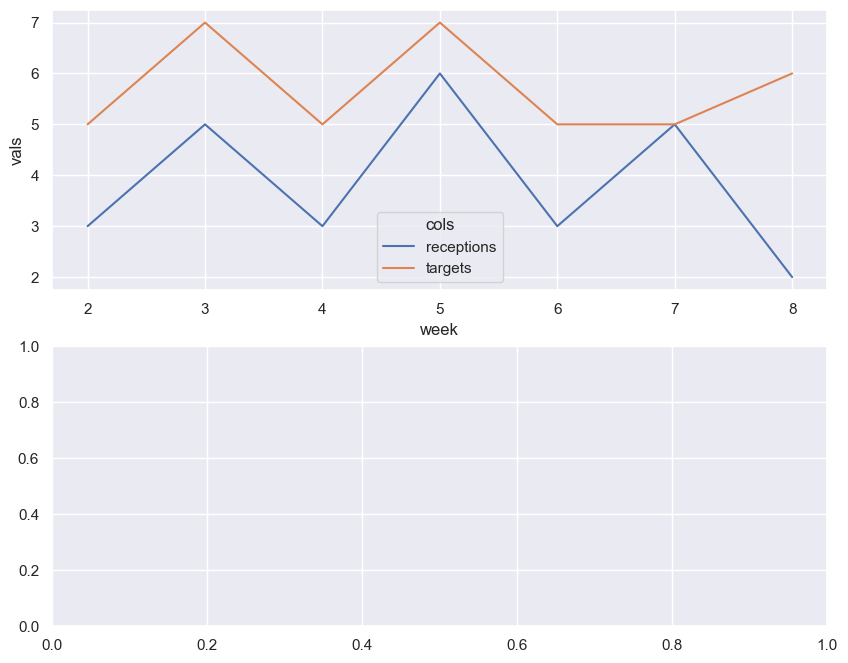

In [65]:
# let's create a reciever viz where we see a recievers targets, receptions, passing share, total passing volume and QBR all in one graph

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, ax = plt.subplots(2,1,figsize = (10,8))

player_id = 'Jerry Jeudy'
ty_hill_data = ngs[(ngs['player_display_name'] == player_id) & (ngs['week'] > 0)][['receptions', 'targets', 'week']].melt('week', var_name = 'cols', value_name = 'vals')
sns.lineplot(data = ty_hill_data, x='week', y = 'vals', hue='cols', ax=ax[0], markers=True)

In [61]:
ngs[(ngs['player_display_name'] == player_id) & (ngs['week'] == 0)][['targets', 'receptions']]

,targets,receptions
10530,87,61


In [68]:
ngs[ngs['week'] != 0].groupby('player_display_name')['targets'].sum().reset_index().sort_values('targets', ascending=False)

,player_display_name,targets
130,Stefon Diggs,90
120,Puka Nacua,89
145,Tyreek Hill,87
62,Ja'Marr Chase,85
0,A.J. Brown,83
...,...,...
99,Marquez Valdes-Scantling,5
76,John Bates,5
85,Justin Watson,5
86,Juwan Johnson,5


In [75]:
df.columns

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'players_on_play',
       'offense_players', 'defense_players', 'n_offense', 'n_defense'],
      dtype='object', length=384)

In [77]:
nfl.import_snap_counts(years = [2023])

,game_id,pfr_game_id,season,game_type,week,player,pfr_player_id,position,team,opponent,offense_snaps,offense_pct,defense_snaps,defense_pct,st_snaps,st_pct
0,2023_01_ARI_WAS,202309100was,2023,REG,1,Saahdiq Charles,CharSa00,T,WAS,ARI,71.0,1.0,0.0,0.0,3.0,0.11
1,2023_01_ARI_WAS,202309100was,2023,REG,1,Andrew Wylie,WyliAn00,G,WAS,ARI,71.0,1.0,0.0,0.0,3.0,0.11
2,2023_01_ARI_WAS,202309100was,2023,REG,1,Charles Leno Jr.,LenoCh00,T,WAS,ARI,71.0,1.0,0.0,0.0,3.0,0.11
3,2023_01_ARI_WAS,202309100was,2023,REG,1,Sam Howell,HoweSa00,QB,WAS,ARI,71.0,1.0,0.0,0.0,0.0,0.00
4,2023_01_ARI_WAS,202309100was,2023,REG,1,Nick Gates,GateNi00,C,WAS,ARI,71.0,1.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11328,2023_08_TB_BUF,202310260buf,2023,REG,8,Zach Triner,TrinZa00,LS,TB,BUF,0.0,0.0,0.0,0.0,9.0,0.35
11329,2023_08_TB_BUF,202310260buf,2023,REG,8,Justin Skule,SkulJu00,T,TB,BUF,0.0,0.0,0.0,0.0,3.0,0.12
11330,2023_08_TB_BUF,202310260buf,2023,REG,8,Chase McLaughlin,McLaCh00,K,TB,BUF,0.0,0.0,0.0,0.0,3.0,0.12
11331,2023_08_TB_BUF,202310260buf,2023,REG,8,Brandon Walton,WaltBr01,G,TB,BUF,0.0,0.0,0.0,0.0,3.0,0.12
